# EDA: data, features, autocorrelation

This notebook is a lightweight exploratory analysis for the competition dataset.
It focuses on:
- schema sanity + basic stats
- target distributions (including `abs(y)` weighting intuition)
- per-feature correlation with targets
- autocorrelation / cross-correlation (lags) inside sequences

Notes:
- `train.parquet` is large; most analyses here sample sequences.
- We use `valid.parquet` by default because it's smaller and usually sufficient for EDA.


In [8]:
import os
import math
import sys
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Optional (nice to have)
try:
    import seaborn as sns
    sns.set_theme(style='whitegrid')
except Exception:
    sns = None

pd.set_option('display.max_columns', 200)
np.set_printoptions(suppress=True, precision=4)

# Make repo root importable (so `import scripts...` works from notebooks/)
REPO_ROOT = Path('..').resolve()
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

DATA_DIR = Path('..') / 'datasets'
TRAIN_PATH = DATA_DIR / 'train.parquet'
VALID_PATH = DATA_DIR / 'valid.parquet'

print('train exists:', TRAIN_PATH.exists(), TRAIN_PATH)
print('valid exists:', VALID_PATH.exists(), VALID_PATH)


train exists: True ../datasets/train.parquet
valid exists: True ../datasets/valid.parquet


## 1) Schema + quick sanity
We expect: 3 meta cols + 32 features + 2 targets = 37 columns.

- meta: `seq_ix`, `step_in_seq`, `need_prediction`
- features: `p0..p11`, `v0..v11`, `dp0..dp3`, `dv0..dv3`
- targets: `t0`, `t1`


In [9]:
import pyarrow.parquet as pq

def parquet_info(path: Path):
    pf = pq.ParquetFile(path)
    schema = pf.schema_arrow
    print('path:', path)
    print('rows:', pf.metadata.num_rows)
    print('row_groups:', pf.metadata.num_row_groups)
    print('ncols:', len(schema.names))
    print('columns:', schema.names[:10], '...')
    return schema.names

cols_valid = parquet_info(VALID_PATH)
cols_train = parquet_info(TRAIN_PATH)


path: ../datasets/valid.parquet
rows: 1444000
row_groups: 2
ncols: 37
columns: ['seq_ix', 'step_in_seq', 'need_prediction', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6'] ...
path: ../datasets/train.parquet
rows: 10721000
row_groups: 11
ncols: 37
columns: ['seq_ix', 'step_in_seq', 'need_prediction', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6'] ...


In [10]:
FEATURE_NAMES = [
    *[f'p{i}' for i in range(12)],
    *[f'v{i}' for i in range(12)],
    *[f'dp{i}' for i in range(4)],
    *[f'dv{i}' for i in range(4)],
]
TARGET_NAMES = ['t0', 't1']
META = ['seq_ix', 'step_in_seq', 'need_prediction']

expected = META + FEATURE_NAMES + TARGET_NAMES
missing = [c for c in expected if c not in cols_valid]
extra = [c for c in cols_valid if c not in expected]
print('missing:', missing)
print('extra:', extra[:20])
print('n_expected:', len(expected))


missing: []
extra: []
n_expected: 37


## 2) Efficient sampling by `seq_ix`
Reading `train.parquet` fully is heavy. We sample sequences for EDA.


In [11]:
def sample_sequences(path: Path, n_seq: int = 200, seed: int = 42):
    # Cheap: read only seq_ix column from parquet
    seq_col = pd.read_parquet(path, columns=['seq_ix'])
    uniq = seq_col['seq_ix'].unique()
    rng = np.random.default_rng(seed)
    choice = rng.choice(uniq, size=min(n_seq, len(uniq)), replace=False)
    return np.array(choice, dtype=np.int64)

def load_by_seq(path: Path, seq_ix: np.ndarray, columns=None):
    df = pd.read_parquet(path, columns=columns)
    return df[df['seq_ix'].isin(seq_ix)].copy()

seq_sample = sample_sequences(VALID_PATH, n_seq=200, seed=42)
df = load_by_seq(VALID_PATH, seq_sample, columns=META + FEATURE_NAMES + TARGET_NAMES)
print(df.shape)
df.head()


(200000, 37)


,seq_ix,step_in_seq,need_prediction,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,dp0,dp1,dp2,dp3,dv0,dv1,dv2,dv3,t0,t1
9000,9,0,0,3.117708,-2.539876,0.865908,2.539824,0.195069,-0.388850,2.863662,-1.341095,-0.341310,-0.675745,0.936237,-2.150848,1.253170,0.243244,-0.503940,0.310363,-0.497458,1.007608,0.229339,-0.103903,0.380122,-0.239512,0.412430,0.884924,2.954185,-1.855904,-2.766229,-2.348309,-0.903301,-0.021329,0.287012,-1.412236,-0.631168,0.118742
9001,9,1,0,3.090878,-3.094500,0.652700,1.376513,-0.161029,-0.784070,2.900021,-1.339903,-0.728494,-2.198898,0.615159,-1.115513,-0.052615,1.524788,-1.149008,1.170180,0.022003,0.609296,0.197429,0.236789,-0.103250,-0.136045,-0.141688,0.598122,-3.035405,2.640745,-1.921200,1.088156,0.016403,1.470615,0.006681,1.131744,-0.870247,-0.130298
9002,9,2,0,2.319615,-2.152394,0.554884,0.722125,-0.378345,-0.549079,2.417399,-0.777606,-0.396813,-1.982075,0.493136,-0.913419,1.017180,-0.092944,-0.829056,0.675957,-0.324589,-0.253601,0.330399,0.123095,0.063132,-0.207890,-0.063161,0.709121,-1.077189,-2.467422,1.896397,2.791004,0.578299,-0.647483,1.081489,-1.075911,-0.870247,-0.383323
9003,9,3,0,1.942703,-1.761948,0.497809,0.795322,-0.280911,-0.387078,2.096521,-0.684763,-0.279923,-1.667612,0.498490,-1.014571,0.878778,0.074033,-0.125629,1.343816,-0.607333,-0.026493,0.330399,0.123095,0.063132,-0.207890,-0.063161,0.709121,0.348110,0.229904,1.271018,0.161909,-0.406079,0.350817,0.357496,0.110627,-1.042384,-0.520793
9004,9,4,0,2.013671,-0.905924,0.627235,0.899534,0.013801,-0.175278,2.033104,-0.692715,-0.091712,-0.772153,0.648724,-1.651703,0.284408,0.288048,-0.899680,0.608505,-0.399561,-0.500826,0.108677,-0.013624,0.125887,-0.202607,0.427784,0.788932,2.205490,-0.061804,-1.678060,-2.138276,-0.965420,0.193143,-0.427976,-1.097845,-0.717236,-0.295661


In [12]:
# Sanity: sequences should be contiguous and step_in_seq should cover 0..999
def sanity_sequences(df: pd.DataFrame, n_show: int = 3):
    for s in df['seq_ix'].unique()[:n_show]:
        sub = df[df['seq_ix'] == s]
        print('seq', s, 'rows', len(sub), 'step_min/max', sub.step_in_seq.min(), sub.step_in_seq.max())
        print('need_prediction true count:', sub.need_prediction.sum())

sanity_sequences(df)


seq 9 rows 1000 step_min/max 0 999
need_prediction true count: 901
seq 32 rows 1000 step_min/max 0 999
need_prediction true count: 901
seq 42 rows 1000 step_min/max 0 999
need_prediction true count: 901


## 3) Target distribution + weighting intuition
Metric weights samples by `abs(y)`, so the tail matters.


In [13]:
df_scored = df.loc[df['need_prediction'].astype(bool)].copy()
print('scored rows:', len(df_scored))
df_scored[TARGET_NAMES].describe().T


scored rows: 180200


,count,mean,std,min,25%,50%,75%,max
t0,180200.0,-0.198868,1.270705,-43.990503,-0.751777,-0.260115,0.115774,36.665128
t1,180200.0,-0.029010,2.011591,-35.986144,-0.849090,-0.028254,0.812071,29.027357


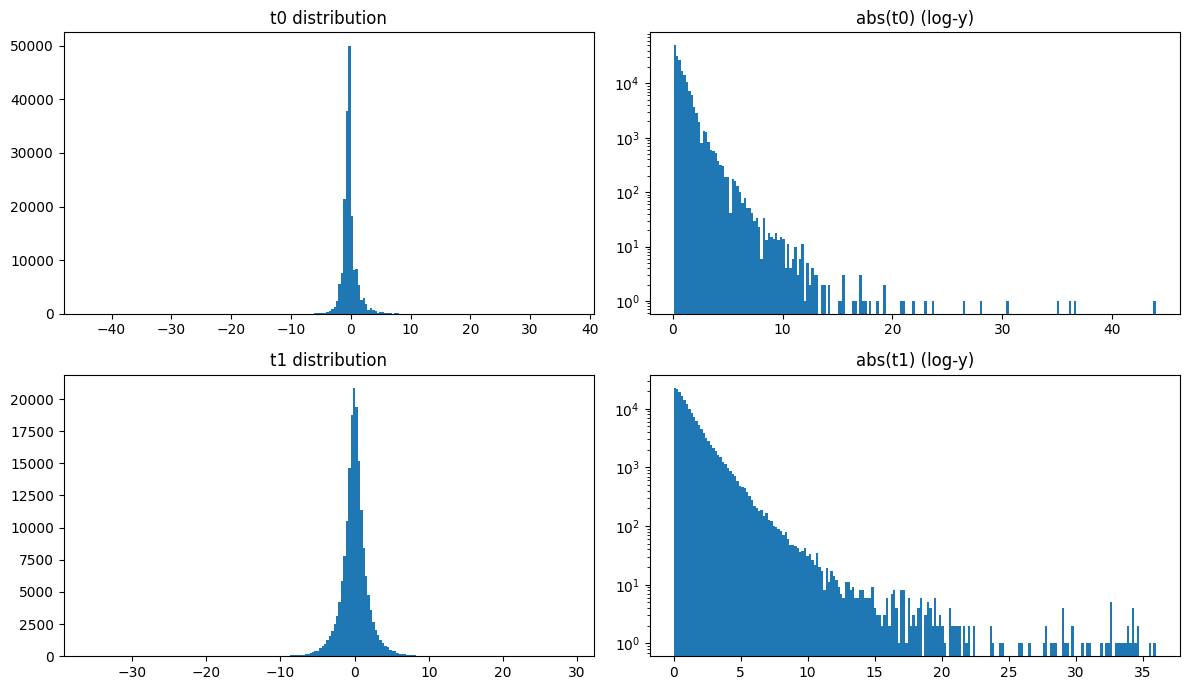

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12, 7))
for i, t in enumerate(TARGET_NAMES):
    ax = axes[i, 0]
    ax.hist(df_scored[t].values, bins=200)
    ax.set_title(f'{t} distribution')

    ax = axes[i, 1]
    ax.hist(np.abs(df_scored[t].values), bins=200, log=True)
    ax.set_title(f'abs({t}) (log-y)')

plt.tight_layout()
plt.show()


## 4) Feature correlation with targets (quick baseline)
We compute simple Pearson correlation feature↔target on scored rows.
This is not the competition metric, but helps spot obviously useful features.


In [15]:
X = df_scored[FEATURE_NAMES].to_numpy(np.float32)
Y = df_scored[TARGET_NAMES].to_numpy(np.float32)

# Standardize features for stable corr
Xz = (X - X.mean(axis=0, keepdims=True)) / (X.std(axis=0, keepdims=True) + 1e-6)

corrs = {}
for j, t in enumerate(TARGET_NAMES):
    y = Y[:, j]
    y = (y - y.mean()) / (y.std() + 1e-6)
    c = (Xz * y[:, None]).mean(axis=0)
    corrs[t] = c

corr_df = pd.DataFrame({
    'feature': FEATURE_NAMES,
    'corr_t0': corrs['t0'],
    'corr_t1': corrs['t1'],
})
corr_df['abs_sum'] = np.abs(corr_df['corr_t0']) + np.abs(corr_df['corr_t1'])
corr_df.sort_values('abs_sum', ascending=False).head(30)


,feature,corr_t0,corr_t1,abs_sum
0,p0,-0.159780,-0.021795,0.181575
2,p2,-0.124449,-0.021974,0.146423
20,v8,0.093871,0.027017,0.120887
8,p8,0.103020,0.009659,0.112679
14,v2,-0.079510,-0.030586,0.110096
4,p4,0.080466,0.019458,0.099924
3,p3,-0.089014,-0.009551,0.098565
31,dv3,0.068121,0.020794,0.088915
12,v0,-0.064082,-0.023546,0.087628
13,v1,0.059851,0.027407,0.087258


## 5) Autocorrelation within sequences
We check how persistent targets (and some features) are over time.
This helps to choose:
- context length
- EWMA alpha
- whether diff features matter


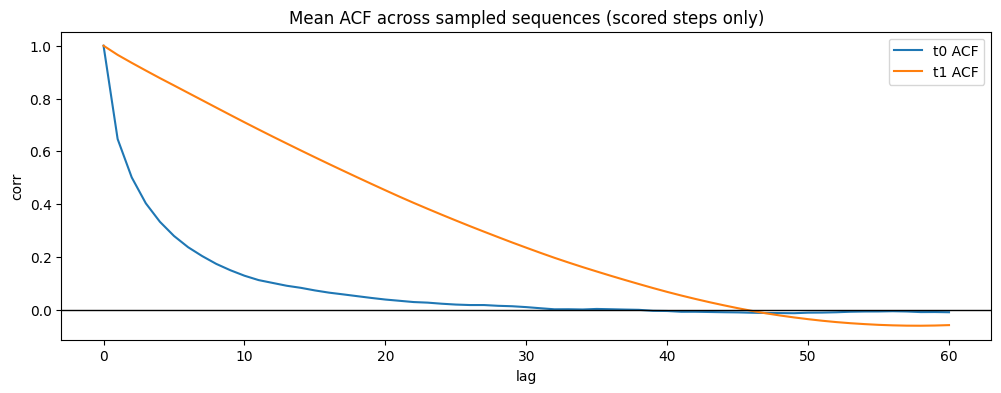

In [16]:
def mean_acf_by_seq(df: pd.DataFrame, col: str, max_lag: int = 50) -> np.ndarray:
    # returns mean ACF[lag] averaged over sequences
    acfs = []
    for s, sub in df.groupby('seq_ix'):
        sub = sub.sort_values('step_in_seq')
        x = sub[col].to_numpy(np.float32)
        x = x - x.mean()
        denom = float((x * x).mean() + 1e-8)
        a = [1.0]
        for lag in range(1, max_lag + 1):
            a.append(float((x[:-lag] * x[lag:]).mean() / denom))
        acfs.append(a)
    return np.mean(np.asarray(acfs), axis=0)

max_lag = 60
acf_t0 = mean_acf_by_seq(df_scored, 't0', max_lag=max_lag)
acf_t1 = mean_acf_by_seq(df_scored, 't1', max_lag=max_lag)

plt.figure(figsize=(12,4))
plt.plot(acf_t0, label='t0 ACF')
plt.plot(acf_t1, label='t1 ACF')
plt.axhline(0, color='black', linewidth=1)
plt.title('Mean ACF across sampled sequences (scored steps only)')
plt.xlabel('lag')
plt.ylabel('corr')
plt.legend()
plt.show()


## 6) Cross-correlation: feature(t) vs target(t+k)
We approximate predictive horizon by checking corr(x_t, y_{t+lag}).
This is not perfect, but often reveals whether very short lags dominate.


top features by simple corr: ['p0', 'p2', 'v8']


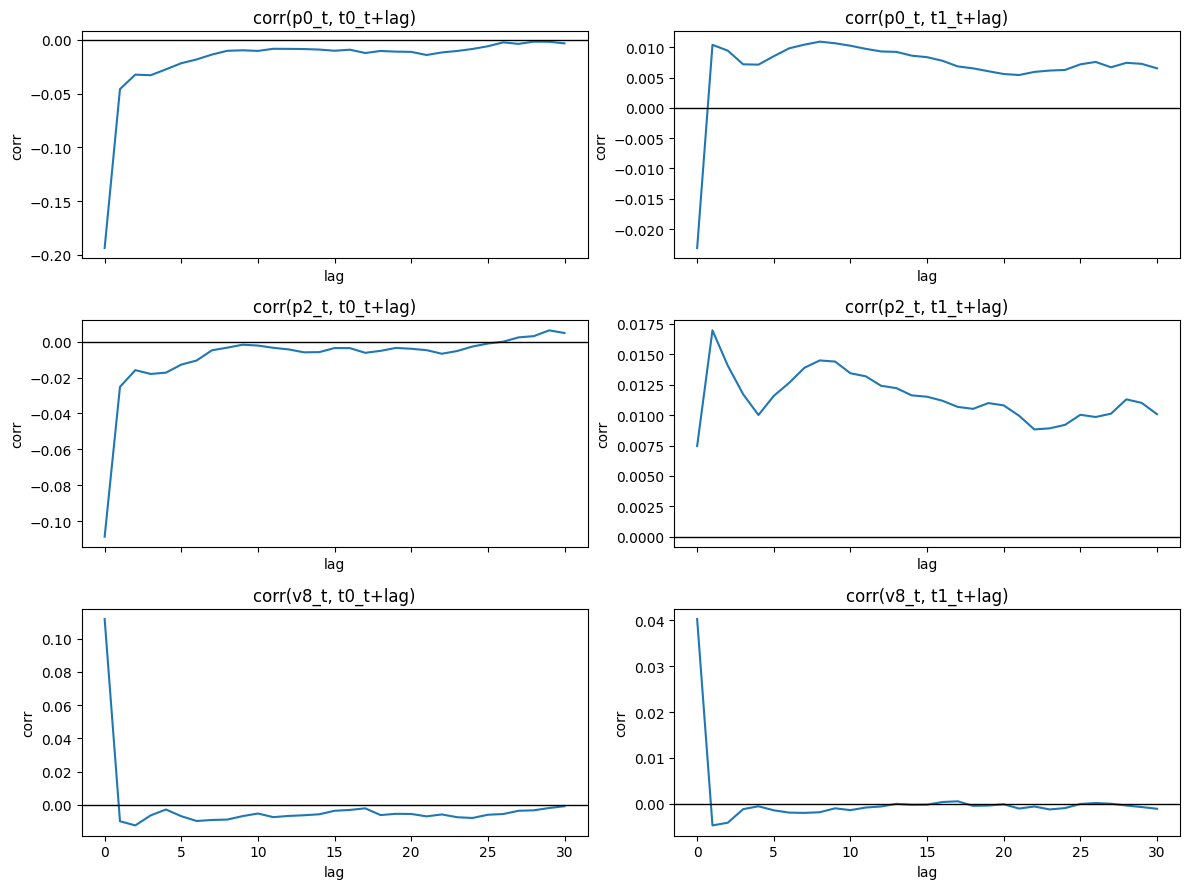

In [17]:
def mean_xcorr_feature_target(df: pd.DataFrame, feature: str, target: str, max_lag: int = 20) -> np.ndarray:
    # corr(x_t, y_{t+lag}) averaged over sequences
    out = []
    for s, sub in df.groupby('seq_ix'):
        sub = sub.sort_values('step_in_seq')
        x = sub[feature].to_numpy(np.float32)
        y = sub[target].to_numpy(np.float32)
        x = (x - x.mean()) / (x.std() + 1e-6)
        y = (y - y.mean()) / (y.std() + 1e-6)
        c = [float((x * y).mean())]
        for lag in range(1, max_lag + 1):
            c.append(float((x[:-lag] * y[lag:]).mean()))
        out.append(c)
    return np.mean(np.asarray(out), axis=0)

top_features = corr_df.sort_values('abs_sum', ascending=False).head(3)['feature'].tolist()
print('top features by simple corr:', top_features)

max_lag = 30
fig, axes = plt.subplots(len(top_features), 2, figsize=(12, 3*len(top_features)), sharex=True)
for i, f in enumerate(top_features):
    for j, t in enumerate(TARGET_NAMES):
        xcorr = mean_xcorr_feature_target(df_scored, f, t, max_lag=max_lag)
        ax = axes[i, j] if len(top_features) > 1 else axes[j]
        ax.plot(xcorr)
        ax.axhline(0, color='black', linewidth=1)
        ax.set_title(f'corr({f}_t, {t}_t+lag)')
        ax.set_ylabel('corr')
        ax.set_xlabel('lag')

plt.tight_layout()
plt.show()


## 7) Feature engineering sanity: diff + EWMA normalization
We show how to compute the exact same engineered features we used in the GRU experiments:
- `diff = x_t - x_{t-1}`
- EWMA mean/var and normalized residual

This helps you debug feature generation and see why it can help.


In [23]:
from scripts.lib_features import build_features_np

seq0 = df[df.seq_ix == df.seq_ix.unique()[0]].sort_values('step_in_seq')
x_seq = seq0[FEATURE_NAMES].to_numpy(np.float32)[None, :, :]

f_raw = build_features_np(x_seq, use_diff=False, use_ewma=False)
f_diff = build_features_np(x_seq, use_diff=True, use_ewma=False)
f_ewma = build_features_np(x_seq, use_diff=False, use_ewma=True, ewma_alpha=0.05)
f_both = build_features_np(x_seq, use_diff=True, use_ewma=True, ewma_alpha=0.05)

print('raw shape:', f_raw.shape)
print('diff shape:', f_diff.shape)
print('ewma shape:', f_ewma.shape)
print('both shape:', f_both.shape)

# Plot one feature and its ewma-normalized version to see the effect
k = 0
plt.figure(figsize=(12,4))
plt.plot(x_seq[0, :, k], label=f'raw {FEATURE_NAMES[k]}')
plt.plot(f_ewma[0, :, 32 + k], label=f'ewma_norm {FEATURE_NAMES[k]}')
plt.legend()
plt.title('Example: raw feature vs EWMA-normalized feature')
plt.show()


ModuleNotFoundError: No module named 'scripts.lib_features'